In [33]:
using PyPlot

matplotlib[:rc]("font", size = 8.0);

In [66]:
function make_realization!(ts, dc, scale)
    randn!(ts);
    for ii=2:length(ts)
        @inbounds ts[ii] = ts[ii-1] + scale*ts[ii];
    end
    n = int(1+rand()*(length(ts)-1));
    v = ts[n];
    for ii=1:length(ts)
        ts[ii] -= v + dc;
    end
    
    return ts;
end

make_realization! (generic function with 1 method)

# IV: Application

## IV.I: Regression Interfase

In [47]:
# regress(R) -> F
#
# Takes in a regressor matrix R and returns a matrix which, when multiplied
# with a data vector, produces the regression.
#
function regress{T<:FloatingPoint}(R::Matrix{T})
    (q,r) = qr(R, thin=true);
    return q*q';
end

# regress(R, y) -> m
#
# Takes a regressor matrix R and applies the specified regression to y
# to return the model fit m.
#
function regress{T<:FloatingPoint}(R::Matrix{T}, y::Vector{T})
    return regress(R)*y;
end

regress (generic function with 2 methods)

## IV.II: Polynomial regression

In [35]:
# polyregressor(n, x) -> R
#
# Produces a regressor matrix for an n-th order polynomial at the given
# x positions suitable for use with regress().
#
function polyregressor{T<:FloatingPoint}(n::Integer, x::Vector{T})
    N = length(x);
    R = Array(T, N, n+1);
    R[:,1] = one(T);
    for ii=2:n+1
        R[:,ii] = R[:,ii-1] .* x;
    end
    return R;
end

function nanpolyregressor{T<:FloatingPoint}(n::Integer, x::Vector{T}, nanz::Vector{Bool})
    w = convert(Vector{T}, ~nanz);
    return diagm(w) * polyregressor(n, x);
end

nanpolyregressor (generic function with 1 method)

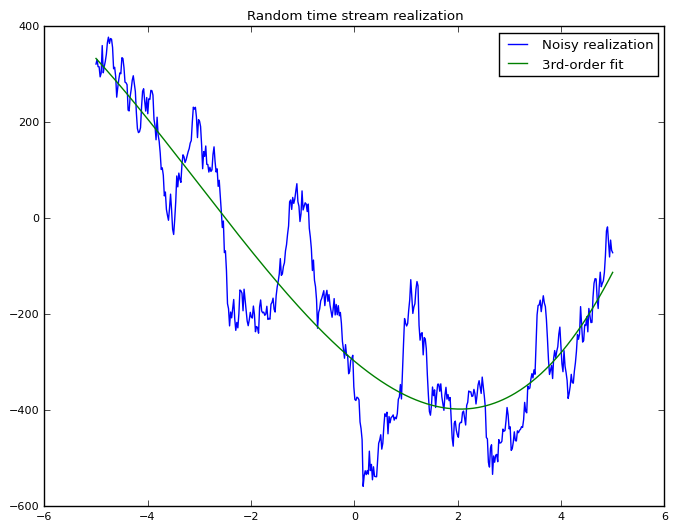

In [67]:
t = linspace(-5,5,500);
v = zeros(size(t));
n = 3;

srand(1)
make_realization!(v, 100, 25);
p = regress(polyregressor(n,t), v);

plot(t,v)
plot(t,p)

title("Regressed random time stream realization")
legend(["Noisy realization", "3rd-order fit"])

savefig("polyregress.png")

# IV.III: Regression filtering

In [73]:
# filt(R) -> F
#
# Takes in a regressor matrix R and returns a matrix which, when multiplied
# with a data vector, filters out the regression from the data.
#
function filt{T<:FloatingPoint}(R::Matrix{T})
    (q,r) = qr(R, thin=true);
    return eye(size(R,1)) - q*q';
end

# filt(R, y) -> m
#
# Takes a regressor matrix R and applies the specified filtering to the
# input data sequence.
#
function filt{T<:FloatingPoint}(R::Matrix{T}, y::Vector{T})
    return filt(R)*y;
end

filt (generic function with 2 methods)

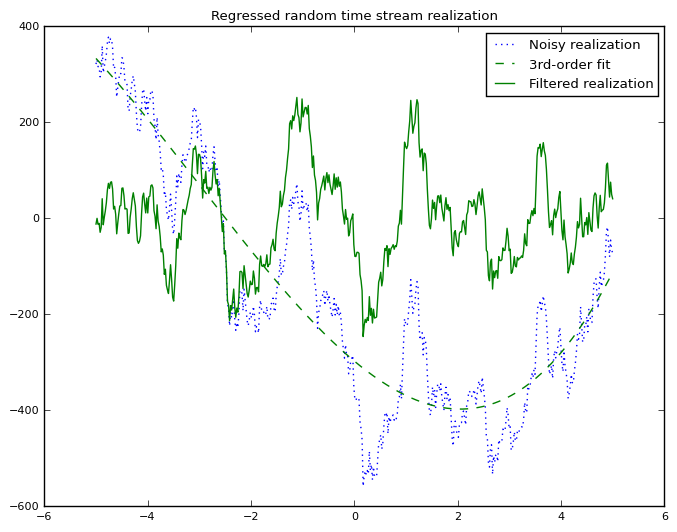

In [79]:
t = linspace(-5,5,500);
v = zeros(size(t));
n = 3;

srand(1)
make_realization!(v, 100, 25);
R = polyregressor(n, t);
p = regress(R, v);
f = filt(R, v);

plot(t,v,"b:")
plot(t,p,"g--")
plot(t,f,"g")

title("Regressed random time stream realization")
legend(["Noisy realization", "3rd-order fit", "Filtered realization"])

savefig("polyfilt.png")

# V: Numerical Tests

In [4]:
x = linspace(-12,12,400);
y = 20 + 10*x - x.^2 / 2 - x.^3 / 20;

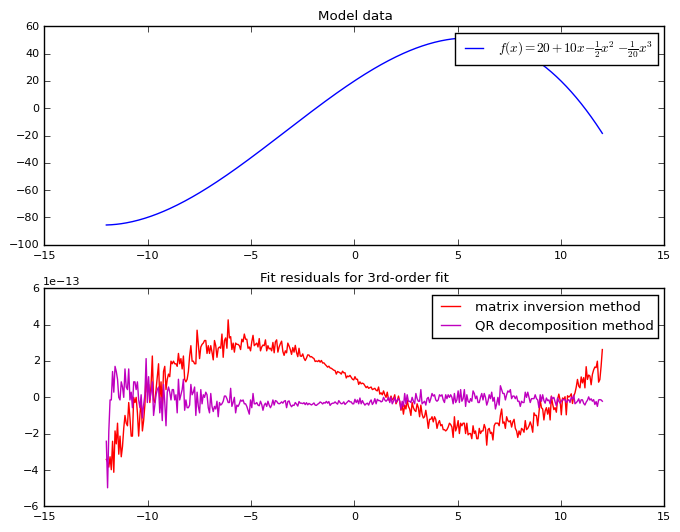

In [5]:
X = polyregressor(3, x);
P1 = X * inv(X'X) * X';

(Q,R) = qr(X, thin=true);
P2 = Q*Q';

subplot(2,1,1)
plot(x, y);

title("Model data")
legend([L"f(x) = 20 + 10x - \frac{1}{2} x^2 - \frac{1}{20} x^3"])

subplot(2,1,2)
plot(x, P1*y .- y, "r")
plot(x, P2*y .- y, "m")
ylim([-6,6]*1e-13);

title("Fit residuals for 3rd-order fit")
legend(["matrix inversion method", "QR decomposition method"])

savefig("residual_3rd.png")

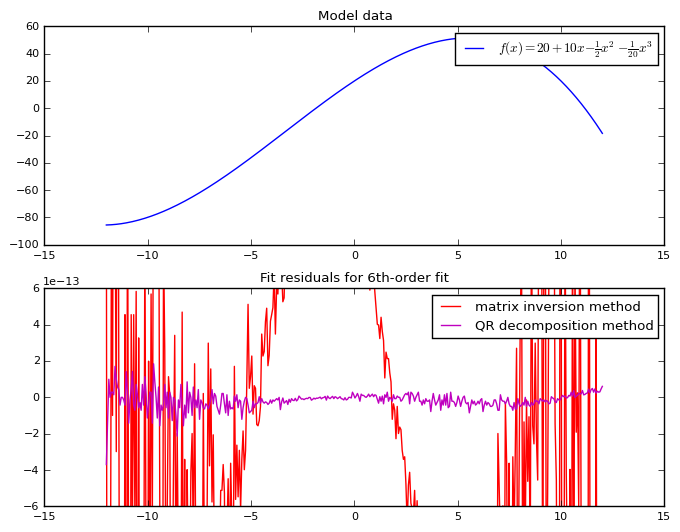

In [6]:
X2 = polyregressor(6, x);
P3 = X2 * inv(X2'X2) * X2';

(Q,R) = qr(X2, thin=true);
P4 = Q*Q';

subplot(2,1,1)
plot(x, y);

title("Model data")
legend([L"f(x) = 20 + 10x - \frac{1}{2} x^2 - \frac{1}{20} x^3"])

subplot(2,1,2)
plot(x, P3*y .- y, "r")
plot(x, P4*y .- y, "m")
ylim([-6,6]*1e-13);

title("Fit residuals for 6th-order fit")
legend(["matrix inversion method", "QR decomposition method"])

savefig("residual_6th.png")